In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym, rec_gym
import numpy as np
import tensorflow as tf

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from agents.utils import ReplayBuffer
from rec_gym.runner import evaluate, play_and_record
import gin
import rec_gym.envs.prim_env_v1

In [4]:
gin.parse_config("""
PrimEnv1.n_items = 100
PrimEnv1.n_users = 10
PrimEnv1.n_rec   = 4
PrimEnv1.embedding_dimension = 2
PrimEnv1.cluster_var = 16
PrimEnv1.in_cluster_var = 4
PrimEnv1.user_change_prob = 0.05
PrimEnv1.reward_noise = 0
PrimEnv1.user_init_sigma = 4
PrimEnv1.user_ar_coef = 1
PrimEnv1.user_drift_sigma = 0
PrimEnv1.seed = 53
PrimEnv1.user_type = 'drifting'
""")

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [6]:
def make_env():
    env = gym.make('prim-gym-v1')
    return env

In [7]:
from agents.ddpg import DDPGAgent 

Using TensorFlow backend.


In [8]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span=100, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

env = make_env()

state_dim = env.embedding_dimension
action_dim = env.embedding_dimension
action_size = env.n_rec

agent = DDPGAgent(action_size = action_size,
                 state_dim = state_dim,
                 action_dim = action_dim,
                 gamma = .9,
                 sess = sess,
                 optimizer = tf.train.AdamOptimizer(
                     learning_rate=0.001
                 ),
                 max_tf_checkpoints_to_keep = 3,
                 experience_size = 1000)

sess.run(tf.global_variables_initializer())
agent.update_target_weights()

exp_replay = ReplayBuffer(10**3)
play_and_record(agent, env, exp_replay, n_steps=500)

0.024

buffer size = 1000, epsilon = 0.92274


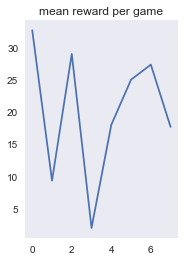

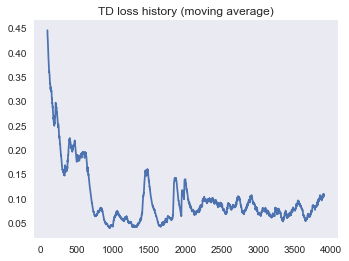

  0%|          | 4000/1000000 [03:51<15:59:37, 17.30it/s]

KeyboardInterrupt: 

In [9]:
batch_size = 64

for i in trange(10**6):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    batch = exp_replay.sample(batch_size)
    loss_t = agent.train(batch) 
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        #load_weigths_into_target_network(agent, target_network)
        #calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        #again and again, which bloat memory consumption along training step
        #create'copy_step' once 
        if i % 2000 == 0:
            agent.update_target_weights() 
        
        #agent.write_summary(step=i)
        # TODO : epsilon scheduler in agent as function
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        
        mean_rw_history.append(evaluate(env, agent, n_games=3, t_max=1000))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [10]:
from agents.utils import data_exploring_widget
data_exploring_widget(env)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time:', max=67229), Output()), …

In [ ]:
import gym.wrappers
env_monitor = gym.wrappers.Monitor(env,directory="./logs/videos/run_diff_ctr/",force=True)
evaluate(env_monitor, agent, n_games=1, t_max=1000) 
env_monitor.close()

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./logs/videos/run_diff_ctr/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./logs/videos/run_diff_ctr/"+video_names[-1]))